<a href="https://colab.research.google.com/github/emmanuelmokel/PPL-practice/blob/main/TFP_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [22]:
# Importing basic packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style = 'white')

In [8]:
# Importing packages for TFP and JAX
import jax.numpy as jnp
from jax import grad
from jax import jit 
from jax import random
from jax import value_and_grad
from jax import vmap
from tensorflow_probability.substrates import jax as tfp

# Setting modules as variables?
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [6]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

In [17]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  w = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape =(num_features, 
                                                               num_classes)))
  b = yield Root(tfd.Sample(tfd.Normal(0., 1.), sample_shape = (num_classes,)))
  logits = jnp.dot(features, w) + b
  yield tfd.Independent(tfd.Categorical(logits = logits), 
                        reinterpreted_batch_ndims = 1)
  
dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
  return dist.log_prob(params + (labels,))

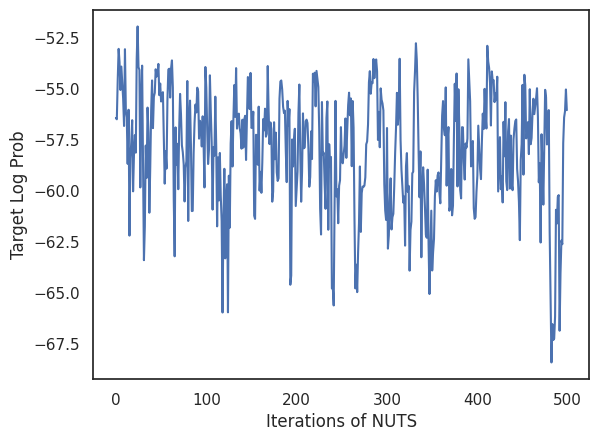

16.29298734664917


In [29]:
import time
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed = init_key)[:-1])

@jit 
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
  return tfp.mcmc.sample_chain(500, current_state = state, kernel = kernel, 
                               trace_fn = lambda _, results: 
                               results.target_log_prob, 
                               num_burnin_steps = 500, seed = key)
start = time.time() 
states, log_probs = run_chain(sample_key, init_params)
end = time.time()
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

print(end-start)

In [31]:
def classifier_probs(params):
  dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
  return dists[-1].distribution.probs_parameter()

all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1)== labels))

Average accuracy: 0.96812
BMA accuracy: 0.9866667
